In [1]:
# =====================================================
# 1. Initialization: Time and System Parameters
# =====================================================
import numpy as np
import pyomo.environ as pyo
import matplotlib.pyplot as plt

# Time settings
control_horizon = 1
prediction_horizon = 12
T_total = 168  # 1 week, 1-hour resolution

# System parameters
eta_ch = 0.95
eta_dch = 0.95
eta_elec = 0.7

SOC_max = 1000
P_bat_max = 200
P_elec_max = 300
H_store_max = 1000

# Cost and price parameters
C_grid_base = 40
C_battery = 1
C_elec = 1
C_Hstore = 0.1
H_price = 10
CO2_tax = 40

# Initial states
SOC_real = [500]         # Battery not empty or full
H_store_real = [300]     # Hydrogen storage partially filled


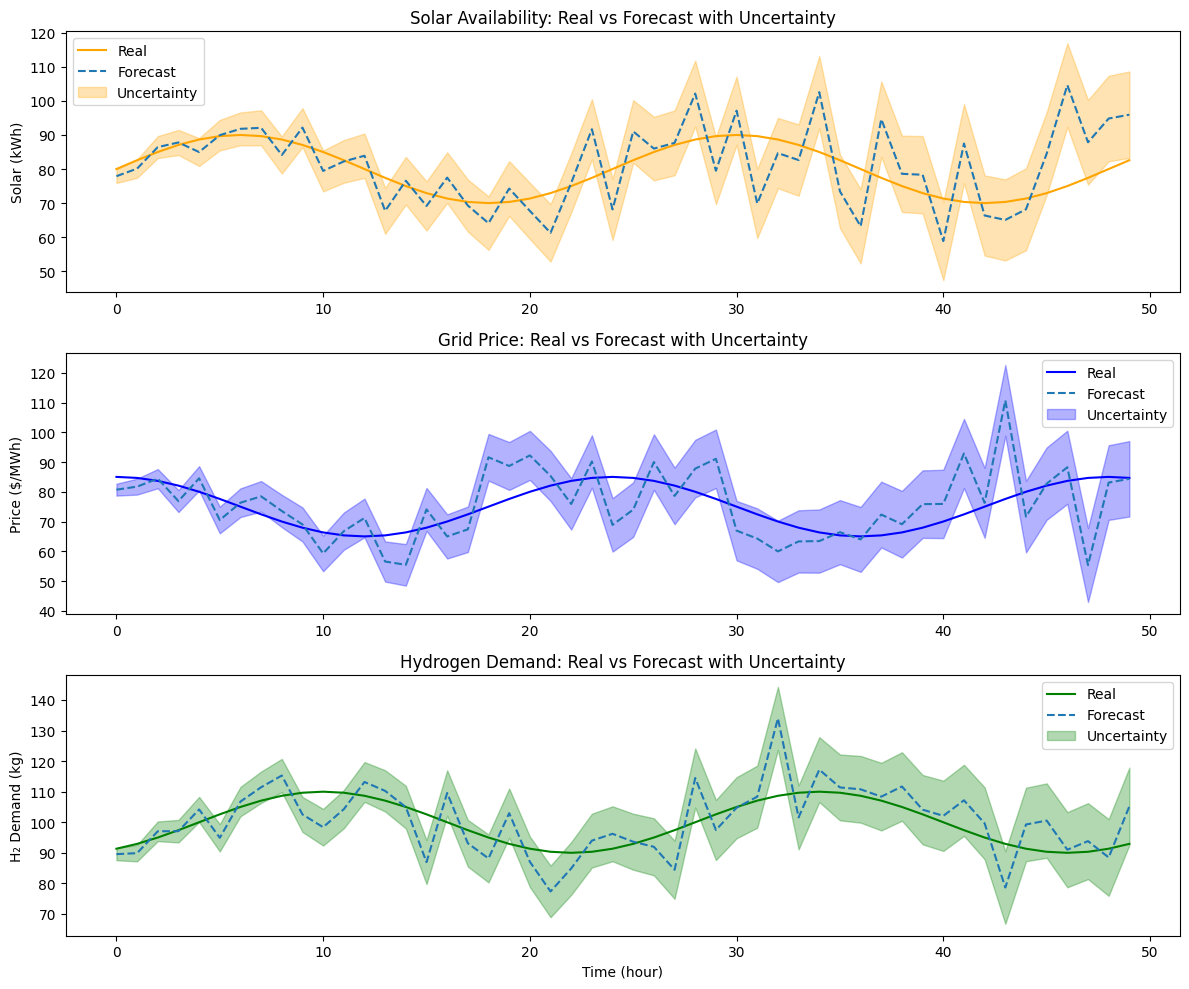

In [2]:
# =====================================================
# 2. Forecast & Real-Time Models + Visualization
# =====================================================
sigma0 = 2
alpha = 0.8

def real_solar(t):
    return 100 * (0.8 + 0.1 * np.sin(2 * np.pi * t / 24))

def real_grid_price(t):
    return 75 + 10 * np.cos(2 * np.pi * t / 24)

def real_hydrogen_demand(t):
    return 100 + 10 * np.sin(2 * np.pi * t / 24 - np.pi / 3)

def forecast_with_uncertainty(real_func, t, delta):
    std = sigma0 * np.sqrt(1 + alpha * delta)
    value = real_func(t) + np.random.normal(0, std)
    return value, std


# Visualize real vs forecast with uncertainty bands
t_vis = np.arange(50)

# Containers
solar_real, solar_forecast, solar_upper, solar_lower = [], [], [], []
grid_real, grid_forecast, grid_upper, grid_lower = [], [], [], []
hydrogen_real, hydrogen_forecast, hydrogen_upper, hydrogen_lower = [], [], [], []

for ti in t_vis:
    real_s = real_solar(ti)
    f_s, std_s = forecast_with_uncertainty(real_solar, ti, ti)
    solar_real.append(real_s)
    solar_forecast.append(f_s)
    solar_upper.append(f_s + std_s)
    solar_lower.append(f_s - std_s)

    real_g = real_grid_price(ti)
    f_g, std_g = forecast_with_uncertainty(real_grid_price, ti, ti)
    grid_real.append(real_g)
    grid_forecast.append(f_g)
    grid_upper.append(f_g + std_g)
    grid_lower.append(f_g - std_g)

    real_h = real_hydrogen_demand(ti)
    f_h, std_h = forecast_with_uncertainty(real_hydrogen_demand, ti, ti)
    hydrogen_real.append(real_h)
    hydrogen_forecast.append(f_h)
    hydrogen_upper.append(f_h + std_h)
    hydrogen_lower.append(f_h - std_h)


# Plot with separate rows
plt.figure(figsize=(12, 10))

# Solar
plt.subplot(3, 1, 1)
plt.plot(t_vis, solar_real, label='Real', color='orange')
plt.plot(t_vis, solar_forecast, '--', label='Forecast')
plt.fill_between(t_vis, solar_lower, solar_upper, color='orange', alpha=0.3, label='Uncertainty')
plt.title("Solar Availability: Real vs Forecast with Uncertainty")
plt.ylabel("Solar (kWh)")
plt.legend()

# Grid Price
plt.subplot(3, 1, 2)
plt.plot(t_vis, grid_real, label='Real', color='blue')
plt.plot(t_vis, grid_forecast, '--', label='Forecast')
plt.fill_between(t_vis, grid_lower, grid_upper, color='blue', alpha=0.3, label='Uncertainty')
plt.title("Grid Price: Real vs Forecast with Uncertainty")
plt.ylabel("Price ($/MWh)")
plt.legend()

# Hydrogen Demand
plt.subplot(3, 1, 3)
plt.plot(t_vis, hydrogen_real, label='Real', color='green')
plt.plot(t_vis, hydrogen_forecast, '--', label='Forecast')
plt.fill_between(t_vis, hydrogen_lower, hydrogen_upper, color='green', alpha=0.3, label='Uncertainty')
plt.title("Hydrogen Demand: Real vs Forecast with Uncertainty")
plt.xlabel("Time (hour)")
plt.ylabel("H₂ Demand (kg)")
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
# Parameters
C_grid_base = 40
C_battery = 1
C_elec = 1
C_Hstore = 0.1
H_price = 10
CO2_tax = 40

In [4]:
# ================================
# Rule-Based Control Initialization
# ================================
SOC_real = [500]
H_store_real = [300]

logs_rbc = {k: [] for k in ["E_sb", "E_be", "E_ge", "P_elec", "H_prod", "H_sales",
                            "H_es", "H_est", "H_hs", "H_ss", "SOC", "H_store", "solar"]}

for t in range(T_total):
    # Real-time inputs
    solar = real_solar(t)
    grid_price = real_grid_price(t)
    H_demand = real_hydrogen_demand(t)
    SOC = SOC_real[-1]
    H_store = H_store_real[-1]

    # Initialize controls
    E_sb = E_be = E_ge = 0
    P_elec = 0
    H_es = H_est = H_ss = 0

    # Available solar power is used for electrolyzer first
    if solar >= P_elec_max:
        P_elec = P_elec_max
        E_sb = min(solar - P_elec_max, P_bat_max) if SOC < 0.8 * SOC_max else 0
    else:
        P_elec = solar
        if SOC < 0.8 * SOC_max:
            E_sb = min(solar - P_elec, P_bat_max) if solar - P_elec > 0 else 0

    # Battery discharge if solar is insufficient
    if P_elec < P_elec_max and SOC > 0.2 * SOC_max:
        avail_batt = min(P_bat_max, SOC * eta_dch)
        add_batt = min(P_elec_max - P_elec, avail_batt)
        E_be = add_batt
        P_elec += E_be

    # Grid supply if solar + battery are insufficient
    if P_elec < P_elec_max:
        E_ge = P_elec_max - P_elec
        P_elec += E_ge

    # Hydrogen production
    H_prod = eta_elec * P_elec

    # Meet demand from production
    if H_prod >= H_demand:
        H_es = H_demand
        if H_store < 0.9 * H_store_max:
            H_est = H_prod - H_es
    else:
        H_es = H_prod
        # Use storage to meet demand
        H_ss = min(H_store, H_demand - H_es)

    H_sales = H_es + H_ss

    # Update states
    SOC_new = SOC + eta_ch * E_sb - E_be / eta_dch
    H_store_new = H_store + H_est - H_ss
    SOC_real.append(SOC_new)
    H_store_real.append(H_store_new)

    # Logging
    logs_rbc["E_sb"].append(E_sb)
    logs_rbc["E_be"].append(E_be)
    logs_rbc["E_ge"].append(E_ge)
    logs_rbc["P_elec"].append(P_elec)
    logs_rbc["H_prod"].append(H_prod)
    logs_rbc["H_sales"].append(H_sales)
    logs_rbc["H_es"].append(H_es)
    logs_rbc["H_est"].append(H_est)
    logs_rbc["H_ss"].append(H_ss)
    logs_rbc["SOC"].append(SOC)
    logs_rbc["H_store"].append(H_store)
    logs_rbc["solar"].append(solar)


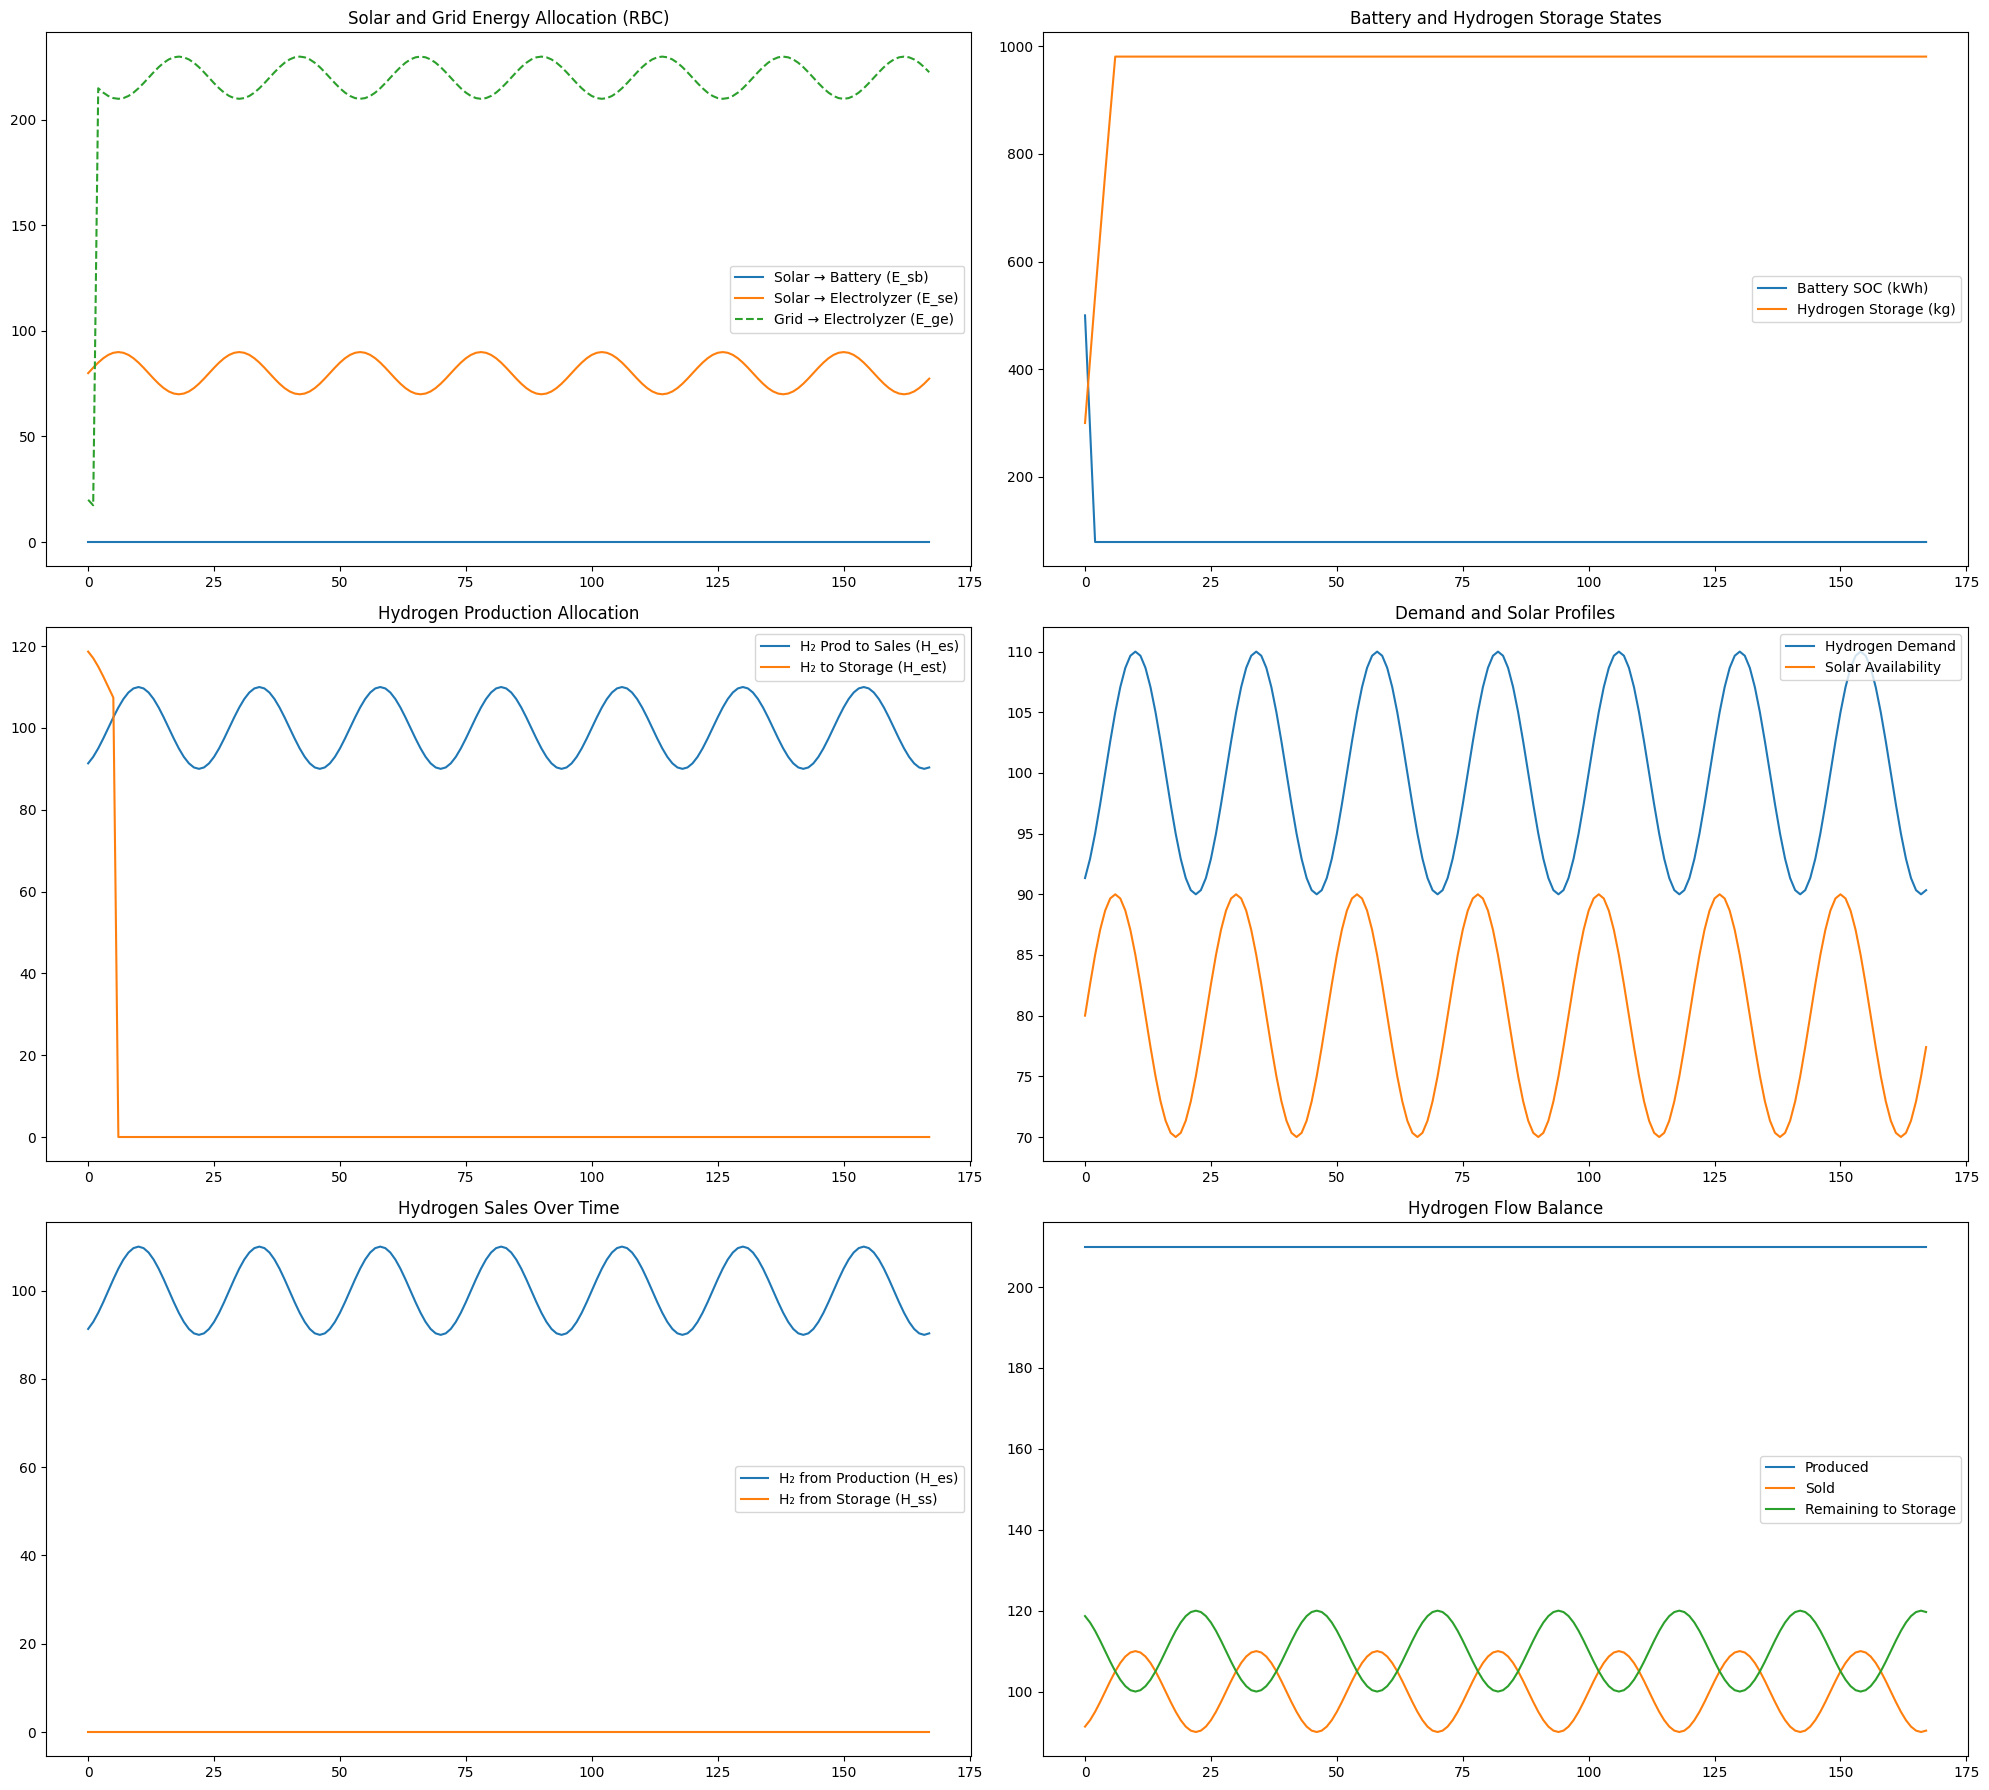

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Extract from logs
time = np.arange(len(logs_rbc["E_sb"]))
E_sb = np.array(logs_rbc["E_sb"])
E_be = np.array(logs_rbc["E_be"])
E_ge = np.array(logs_rbc["E_ge"])
P_elec = np.array(logs_rbc["P_elec"])
H_prod = np.array(logs_rbc["H_prod"])
H_es = np.array(logs_rbc["H_es"])
H_est = np.array(logs_rbc["H_est"])
H_sales = np.array(logs_rbc["H_sales"])
SOC = np.array(logs_rbc["SOC"])
H_store = np.array(logs_rbc["H_store"])
H_ss = np.array(logs_rbc["H_ss"])
solar = np.array(logs_rbc["solar"])
real_demand = np.array([real_hydrogen_demand(t) for t in time])
real_solar = np.array([real_solar(t) for t in time])

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
axs = axs.ravel()

# 1. Solar and Grid Allocation
axs[0].plot(time, E_sb, label='Solar → Battery (E_sb)')
axs[0].plot(time, solar - E_sb, label='Solar → Electrolyzer (E_se)')
axs[0].plot(time, E_ge, label='Grid → Electrolyzer (E_ge)', linestyle='--')
axs[0].set_title("Solar and Grid Energy Allocation (RBC)")
axs[0].legend()

# 2. Battery and Hydrogen Storage
axs[1].plot(time, SOC, label='Battery SOC (kWh)')
axs[1].plot(time, H_store, label='Hydrogen Storage (kg)')
axs[1].set_title("Battery and Hydrogen Storage States")
axs[1].legend()

# 3. Electrolyzer Output and Allocation
axs[2].plot(time, H_es, label='H₂ Prod to Sales (H_es)')
axs[2].plot(time, H_est, label='H₂ to Storage (H_est)')
axs[2].set_title("Hydrogen Production Allocation")
axs[2].legend()

# 4. Demand and Solar
axs[3].plot(time, real_demand, label='Hydrogen Demand')
axs[3].plot(time, real_solar, label='Solar Availability')
axs[3].set_title("Demand and Solar Profiles")
axs[3].legend()

# 5. Hydrogen Sales
axs[4].plot(time, H_es, label='H₂ from Production (H_es)')
axs[4].plot(time, H_ss, label='H₂ from Storage (H_ss)')
axs[4].set_title("Hydrogen Sales Over Time")
axs[4].legend()

# 6. Hydrogen Balance
axs[5].plot(time, H_prod, label='Produced')
axs[5].plot(time, H_sales, label='Sold')
axs[5].plot(time, H_prod - H_sales, label='Remaining to Storage')
axs[5].set_title("Hydrogen Flow Balance")
axs[5].legend()

plt.tight_layout()
plt.show()


In [6]:
# === ENERGY METRICS ===
solar_to_battery = np.sum(E_sb)
solar_to_electrolyzer = np.sum(P_elec - E_be - E_ge)
battery_discharge = np.sum(E_be)
grid_energy = np.sum(E_ge)
electrolyzer_energy = np.sum(P_elec)

# === HYDROGEN METRICS ===
hydrogen_produced = np.sum(H_prod)
hydrogen_sold_total = np.sum(H_sales)
hydrogen_sold_from_prod = np.sum(H_es)
hydrogen_sold_from_storage = np.sum(H_ss)
hydrogen_to_storage = np.sum(H_est)

# === COSTS ===
grid_cost = np.sum(E_ge * (C_grid_base + CO2_tax))
battery_cost = np.sum(C_battery * (E_sb + E_be))
electrolyzer_cost = np.sum(C_elec * P_elec)
storage_cost = np.sum(C_Hstore * H_store)
total_cost = grid_cost + battery_cost + electrolyzer_cost + storage_cost

# === REVENUE & PROFIT ===
revenue = np.sum(H_price * H_sales)
net_profit = revenue - total_cost

# === KPI SUMMARY ===
kpi_rbc = {
    "Solar Used (E_se)": solar_to_electrolyzer,
    "Grid Energy Used (E_ge)": grid_energy,
    "Battery Charge (E_sb)": solar_to_battery,
    "Battery Discharge (E_be)": battery_discharge,
    "Electrolyzer Energy": electrolyzer_energy,
    "Hydrogen Produced": hydrogen_produced,
    "Hydrogen Sold (Total)": hydrogen_sold_total,
    "Hydrogen Sold from Production (H_es)": hydrogen_sold_from_prod,
    "Hydrogen Sold from Storage (H_ss)": hydrogen_sold_from_storage,
    "Hydrogen Sent to Storage (H_est)": hydrogen_to_storage,
    "Revenue from H₂ Sales": revenue,
    "Grid Cost": grid_cost,
    "Battery Cost": battery_cost,
    "Electrolyzer Cost": electrolyzer_cost,
    "Storage Cost": storage_cost,
    "Total Cost": total_cost,
    "Net Profit": net_profit,
    "Hydrogen Utilization (%)": 100 * hydrogen_sold_total / hydrogen_produced if hydrogen_produced > 0 else 0
}

for k, v in kpi_rbc.items():
    print(f"{k:40s}: {v:.2f}")


Solar Used (E_se)                       : 13440.00
Grid Energy Used (E_ge)                 : 36560.00
Battery Charge (E_sb)                   : 0.00
Battery Discharge (E_be)                : 400.00
Electrolyzer Energy                     : 50400.00
Hydrogen Produced                       : 35280.00
Hydrogen Sold (Total)                   : 16800.00
Hydrogen Sold from Production (H_es)    : 16800.00
Hydrogen Sold from Storage (H_ss)       : 0.00
Hydrogen Sent to Storage (H_est)        : 680.73
Revenue from H₂ Sales                   : 168000.00
Grid Cost                               : 2924800.00
Battery Cost                            : 400.00
Electrolyzer Cost                       : 50400.00
Storage Cost                            : 16242.02
Total Cost                              : 2991842.02
Net Profit                              : -2823842.02
Hydrogen Utilization (%)                : 47.62


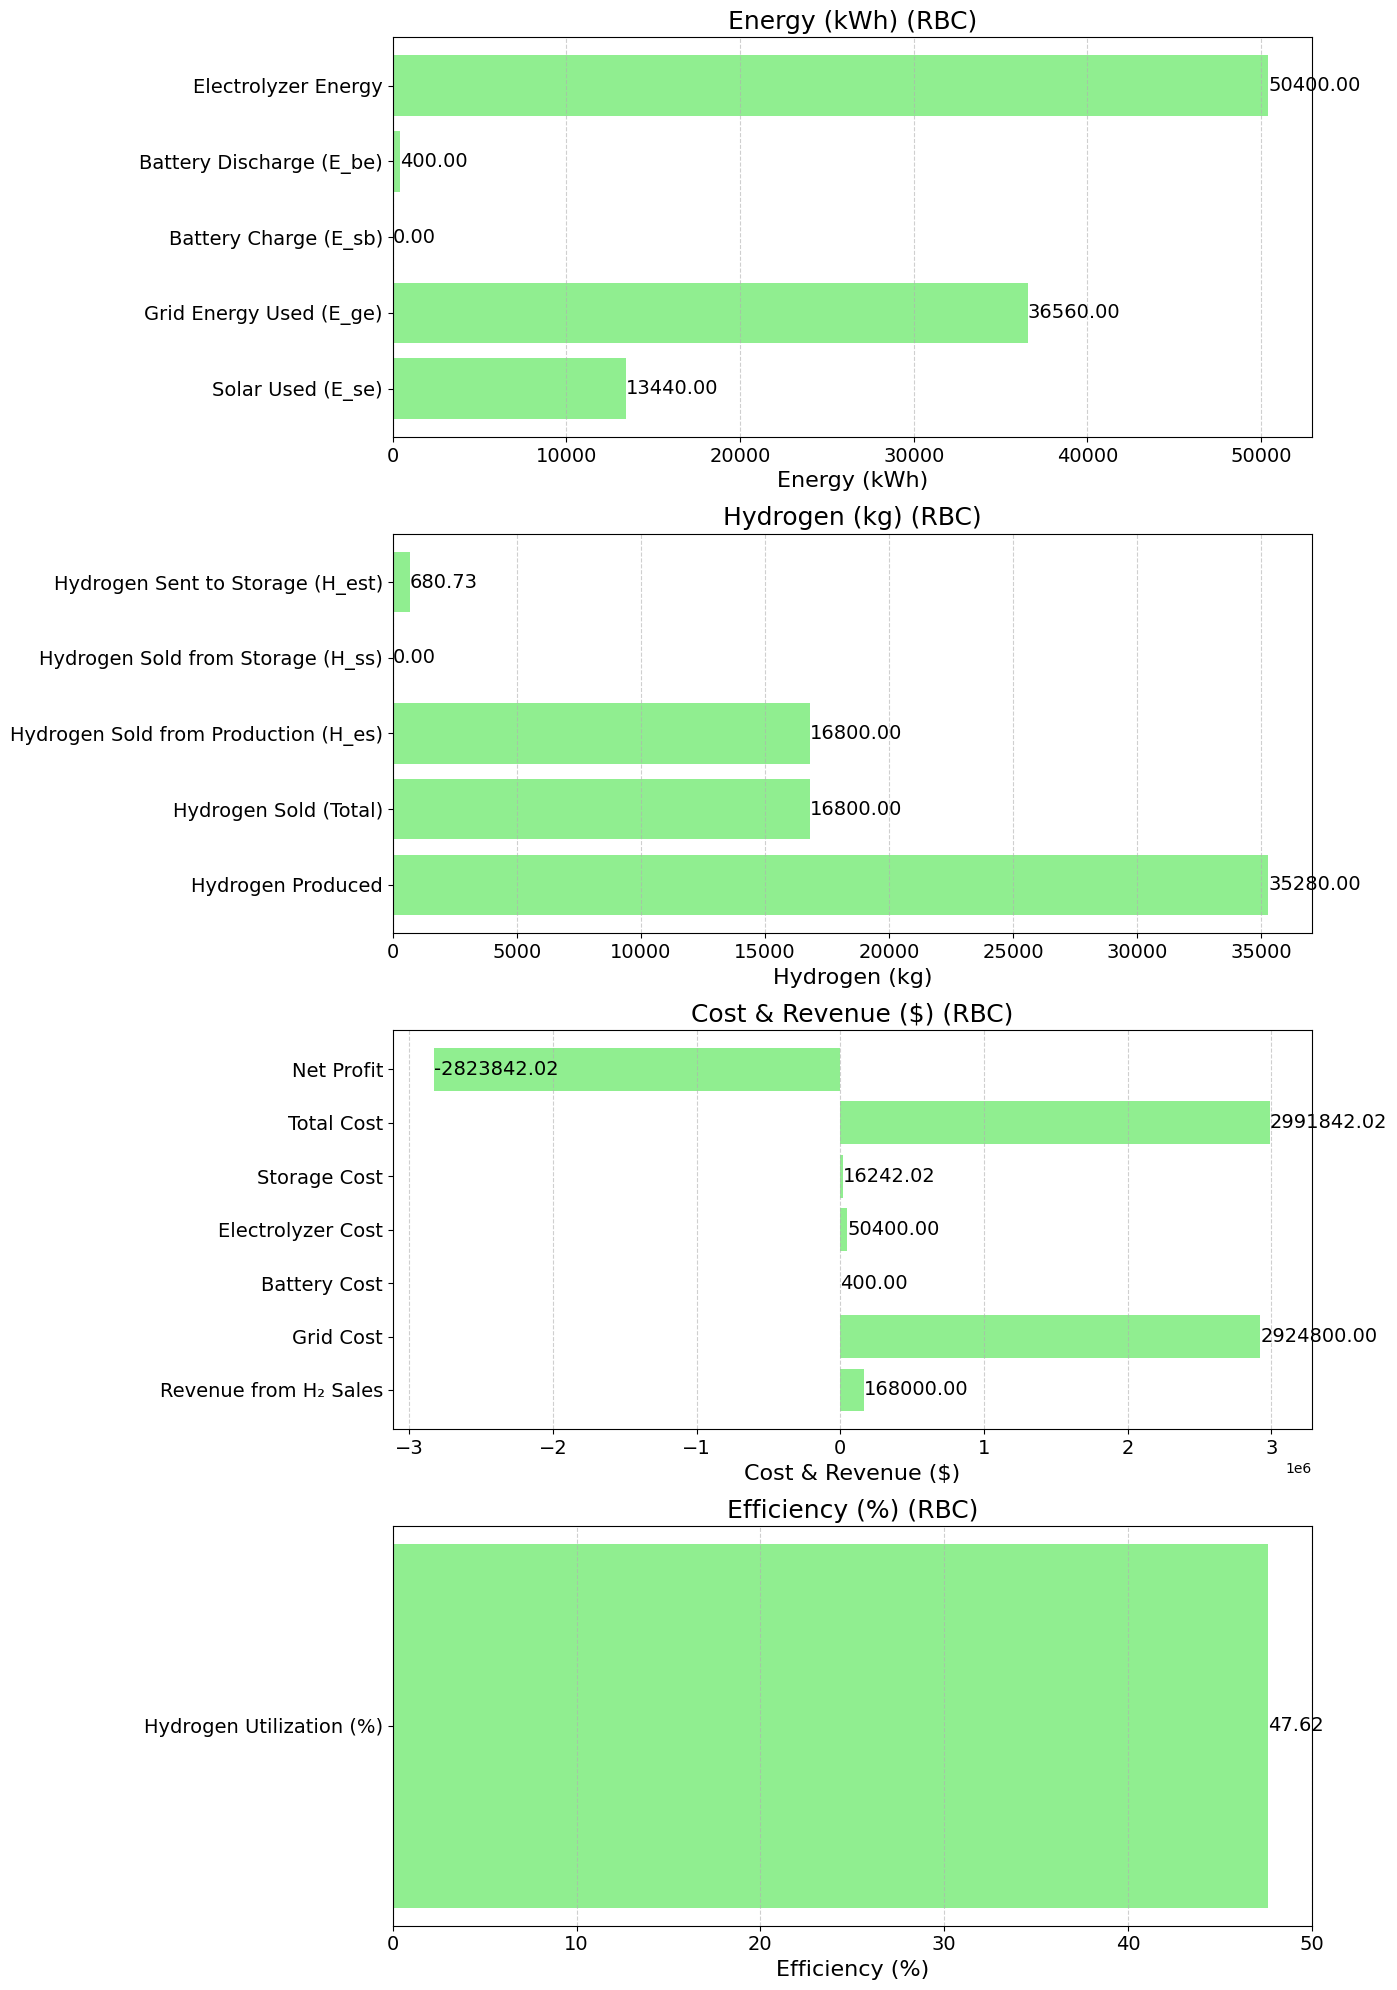

In [7]:
# === Reuse category mapping ===
categories = {
    "Energy (kWh)": ["Solar Used (E_se)", "Grid Energy Used (E_ge)", "Battery Charge (E_sb)", "Battery Discharge (E_be)", "Electrolyzer Energy"],
    "Hydrogen (kg)": ["Hydrogen Produced", "Hydrogen Sold (Total)", "Hydrogen Sold from Production (H_es)", "Hydrogen Sold from Storage (H_ss)", "Hydrogen Sent to Storage (H_est)"],
    "Cost & Revenue ($)": ["Revenue from H₂ Sales", "Grid Cost", "Battery Cost", "Electrolyzer Cost", "Storage Cost", "Total Cost", "Net Profit"],
    "Efficiency (%)": ["Hydrogen Utilization (%)"]
}

# === Plotting RBC KPIs ===
fig, axs = plt.subplots(len(categories), 1, figsize=(14, 20))

for ax, (title, keys) in zip(axs, categories.items()):
    values = [kpi_rbc[k] for k in keys]
    bars = ax.barh(keys, values, color='lightgreen')
    
    ax.set_title(title + " (RBC)", fontsize=18)
    ax.set_xlabel(title, fontsize=16)
    ax.tick_params(axis='both', labelsize=14)
    
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}', va='center', ha='left', fontsize=14)
    
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()
